In [ ]:
#!pip3 install tqdm

In [2]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display
from matplotlib import pyplot as plt

In [3]:
dir_train_l = 'C:\\_pfm\\img\\train_l'
dir_train_s = 'C:\\_pfm\\img\\train_s'

dir_test_l = 'C:\\_pfm\\img\\test_l'
dir_test_s = 'C:\\_pfm\\img\\test_s'

In [4]:
# We create training and validation datasets via image_dataset_from_directory.

crop_size = 300
batch_size = 8

train_in_ds = image_dataset_from_directory(
    dir_train_s,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    seed=101,
    label_mode=None,
)

train_out_ds = image_dataset_from_directory(
    dir_train_l,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    seed=101,
    label_mode=None,
)

Found 200 files belonging to 1 classes.
Found 200 files belonging to 1 classes.


In [5]:
# We rescale the images to take values in the range [0, 1].

def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

# Scale from (0, 255) to (0, 1)
train_in_ds = train_in_ds.map(scaling)
train_out_ds = train_out_ds.map(scaling)

In [6]:
# Build a model

def get_model(channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels*8, 3, **conv_args)(x)
    outputs = layers.Conv2D(1, 3, **conv_args)(x)
    #outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [7]:
# Define ModelCheckpoint and EarlyStopping callbacks.

early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=5)

checkpoint_filepath = ".//tmp-checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model()
model.summary()

#callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
callbacks = [early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 8)     2312      
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 1)     73        
                                                                 
Total params: 59,441
Trainable params: 59,441
Non-trainable p

In [8]:
def process_image(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y

train_in_ds_p = train_in_ds.map(
    lambda x: (process_image(x))
)
train_out_ds_p = train_out_ds.map(
    lambda x: (process_image(x))
)

train_ds = tf.data.Dataset.zip((train_in_ds_p, train_out_ds_p))

train_ds = train_ds.prefetch(buffer_size=32)

In [9]:
# Train the model

epochs = 100

model.compile(optimizer=optimizer, loss=loss_fn)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, verbose=1
)
    #train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/100
25/25 [==============================] - 68s 3s/step - loss: 0.0722
Epoch 2/100
25/25 [==============================] - 70s 3s/step - loss: 0.0038
Epoch 3/100
25/25 [==============================] - 70s 3s/step - loss: 0.0017
Epoch 4/100
25/25 [==============================] - 70s 3s/step - loss: 0.0014
Epoch 5/100
25/25 [==============================] - 70s 3s/step - loss: 0.0012
Epoch 6/100
25/25 [==============================] - 70s 3s/step - loss: 0.0012
Epoch 7/100
25/25 [==============================] - 71s 3s/step - loss: 0.0011
Epoch 8/100
25/25 [==============================] - 71s 3s/step - loss: 0.0011
Epoch 9/100
25/25 [==============================] - 72s 3s/step - loss: 0.0011
Epoch 10/100
25/25 [==============================] - 76s 3s/step - loss: 0.0011
Epoch 11/100
25/25 [==============================] - 74s 3s/step - loss: 0.0011
Epoch 12/100
25/25 [==============================] - 74s 3s/step - loss: 0.0011
Epoch 13/100
25/25 [=================

In [10]:
# Define utility functions

import PIL

def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [11]:
# Run model prediction and plot the results.

img_path_l = dir_test_l + '\\file8000_high.jpg'
img_path_s = dir_test_s + '\\file8000_redu.jpg'

print(img_path_l)
print(img_path_s)

C:\_pfm\img\test_l\file8000_high.jpg
C:\_pfm\img\test_s\file8000_redu.jpg


In [12]:
img_l = load_img(img_path_l)
img_s = load_img(img_path_s)

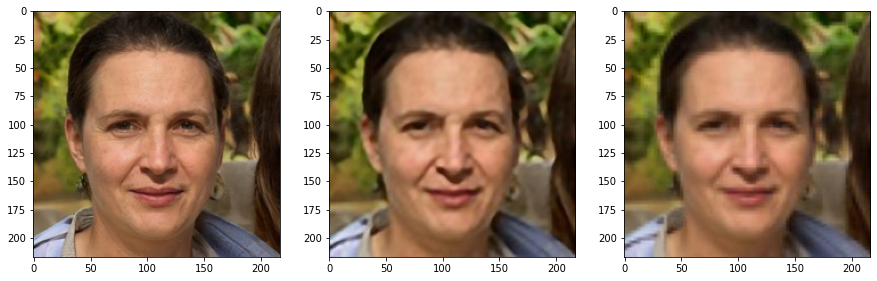

In [13]:
w = img_s.size[0]
h = img_s.size[1]

highres_img = img_l.resize((w, h))
lowres_img = img_s.resize((w, h))
prediction = upscale_image(model, img_s)
pred_img = prediction.resize((w, h))

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(highres_img)
ax[1].imshow(pred_img)
ax[2].imshow(lowres_img)